In [1]:
from ast import literal_eval
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.Chem import QED
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [3]:
final_df = pd.read_csv(f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t")
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_34,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],inactive,inactive,NaN,active,acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_34,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],NaN,NaN,active,NaN,fungi


# Chemphys properties

In [4]:
cmp_df = final_df[
    [
        "compound_smiles",
        "best_class",
        "gram-positive_label",
        "gram-negative_label",
        "fungi_label",
        "acid-fast_label",
    ]
].copy()
cmp_df = cmp_df.drop_duplicates()

cmp_df.head(2)

,compound_smiles,best_class,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label
0,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,acid-fast,inactive,inactive,NaN,active
1,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,fungi,NaN,NaN,active,NaN


In [5]:
data = []
for smile in tqdm(cmp_df["compound_smiles"].values):
    mol = MolFromSmiles(smile)

    p = QED.properties(mol)
    alerts = [i for i in p][-1]

    data.append(
        {
            "compound_smiles": smile,
            "mol_wt": Descriptors.MolWt(mol),
            "tpsa": Descriptors.TPSA(mol),
            "fraction_sp3": Descriptors.FractionCSP3(mol),
            "n_hba": Descriptors.NumHAcceptors(mol),
            "n_hbd": Descriptors.NumHDonors(mol),
            "logp": Descriptors.MolLogP(mol),
            "alerts": alerts,
        }
    )

tmp_df = pd.DataFrame(data)

100%|██████████| 74202/74202 [01:54<00:00, 647.76it/s]


In [6]:
cmp_df = pd.merge(cmp_df, tmp_df, on="compound_smiles")

In [7]:
def check_ro5_violation(molecular_weight, n_hba, n_hbd, logp):
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return ro5_fulfilled

In [8]:
cmp_df["ro5_violation"] = cmp_df.apply(
    lambda x: check_ro5_violation(x["mol_wt"], x["n_hba"], x["n_hbd"], x["logp"]),
    axis=1,
)

In [9]:
k = cmp_df["ro5_violation"].value_counts().reset_index()
k.rename(columns={"index": "Ro5 Violation", "ro5_violation": "Count"}, inplace=True)
k["Normalized"] = k["Count"] / k["Count"].sum() * 100
k

,Ro5 Violation,Count,Normalized
0,True,55814,75.218997
1,False,18388,24.781003


In [10]:
t = []
for class_name in cmp_df["best_class"].unique():
    tmp = cmp_df[cmp_df["best_class"] == class_name]
    tmp = tmp.drop_duplicates(subset="compound_smiles")
    alert_counter = list(tmp["alerts"].value_counts().to_dict().values())
    no_alerts = alert_counter[0]
    combined_alerts = sum(alert_counter[1:])

    ro5_violation = tmp["ro5_violation"].value_counts().to_dict()

    t.append(
        {
            "class": class_name,
            "n": len(tmp),
            "ro5_vol_n": ro5_violation[True],
            "ro5_violation": f"{ro5_violation[True]} ({ro5_violation[True] / sum(ro5_violation.values()) * 100:.2f})",
            "structural_alerts": len(alert_counter),
            "no_alerts": f"{no_alerts} ({no_alerts / sum(alert_counter) * 100:.2f})",
            "alerts": f"{combined_alerts} ({combined_alerts / sum(alert_counter) * 100:.2f})",
        }
    )

pd.DataFrame(t)

,class,n,ro5_vol_n,ro5_violation,structural_alerts,no_alerts,alerts
0,acid-fast,7306,6022,6022 (82.43),7,2393 (32.75),4913 (67.25)
1,fungi,9539,7670,7670 (80.41),8,2994 (31.39),6545 (68.61)
2,gram-negative,11354,8872,8872 (78.14),12,3171 (27.93),8183 (72.07)
3,gram-positive,26435,17578,17578 (66.50),9,8136 (30.78),18299 (69.22)
4,inactive,19568,15672,15672 (80.09),8,5783 (29.55),13785 (70.45)


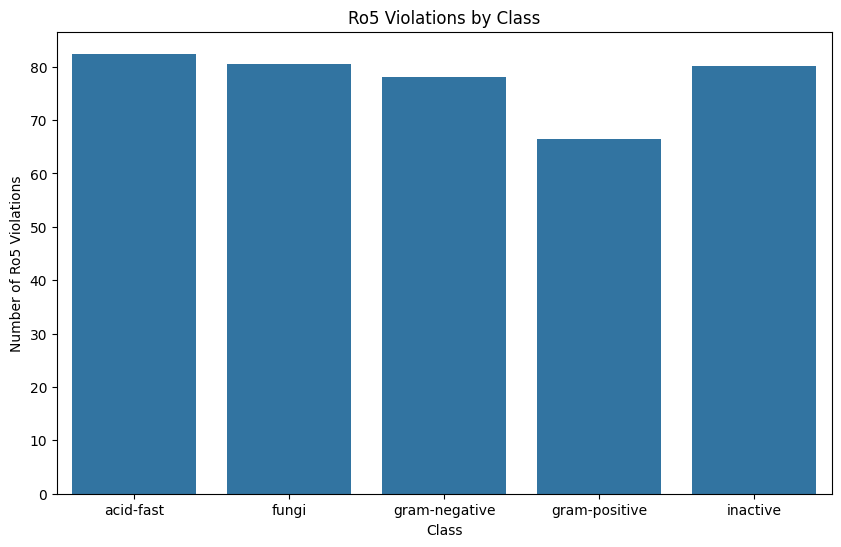

In [11]:
pp = pd.DataFrame(t)
pp["ro5_vol_n"] = pp["ro5_vol_n"] / pp["n"] * 100
plt.figure(figsize=(10, 6))
sns.barplot(x="class", y="ro5_vol_n", data=pp)
plt.ylabel("Number of Ro5 Violations")
plt.xlabel("Class")
plt.title("Ro5 Violations by Class")
plt.show()

In [12]:
t = []
for col in [
    "gram-positive_label",
    "gram-negative_label",
    "fungi_label",
    "acid-fast_label",
]:
    tmp = cmp_df[["compound_smiles", col, "alerts", "ro5_violation"]].dropna()
    tmp = tmp.drop_duplicates(subset="compound_smiles")
    for class_type in tmp[col].unique():
        tmp2 = tmp[tmp[col] == class_type]
        alert_counter = list(tmp2["alerts"].value_counts().to_dict().values())
        no_alerts = alert_counter[0]
        combined_alerts = sum(alert_counter[1:])

        ro5_violation = tmp2["ro5_violation"].value_counts().to_dict()[True]

        t.append(
            {
                "class": col,
                "subclass": class_type,
                "n": len(tmp2),
                "ro5_violation": f"{ro5_violation} ({ro5_violation / len(tmp2) * 100:.2f})",
                "structural_alerts": len(alert_counter),
                "no_alerts": f"{no_alerts} ({no_alerts / sum(alert_counter) * 100:.2f})",
                "alerts": f"{combined_alerts} ({combined_alerts / sum(alert_counter) * 100:.2f})",
            }
        )
pd.DataFrame(t)

,class,subclass,n,ro5_violation,structural_alerts,no_alerts,alerts
0,gram-positive_label,inactive,28568,21450 (75.08),8,8149 (28.52),20419 (71.48)
1,gram-positive_label,active,17530,11511 (65.66),9,5747 (32.78),11783 (67.22)
2,gram-negative_label,inactive,29415,22146 (75.29),12,8257 (28.07),21158 (71.93)
3,gram-negative_label,active,11583,8651 (74.69),9,3819 (32.97),7764 (67.03)
4,fungi_label,active,4282,3288 (76.79),8,1293 (30.20),2989 (69.80)
5,fungi_label,inactive,13782,11492 (83.38),8,4201 (30.48),9581 (69.52)
6,acid-fast_label,active,3958,3153 (79.66),7,1217 (30.75),2741 (69.25)
7,acid-fast_label,inactive,7631,6491 (85.06),8,2412 (31.61),5219 (68.39)


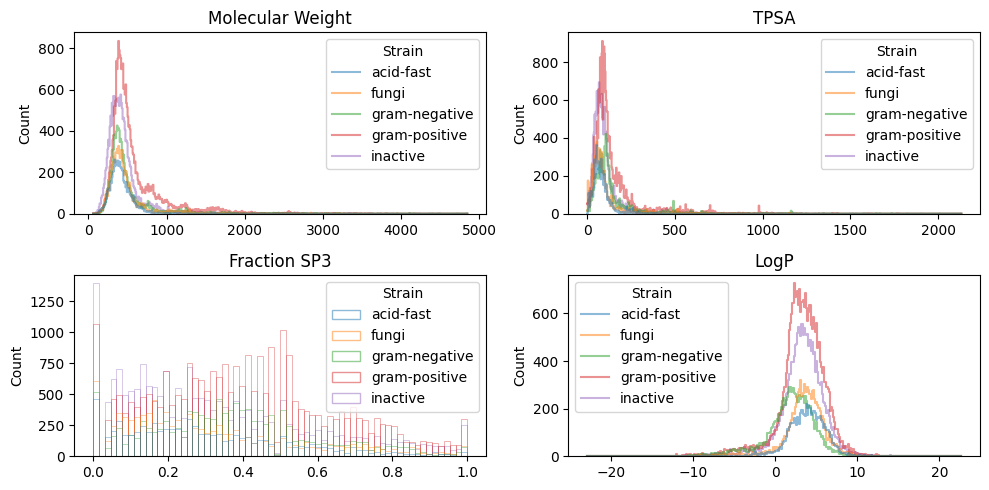

In [13]:
cmp_df.rename(columns={"best_class": "Strain"}, inplace=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))

sns.histplot(
    data=cmp_df, x="mol_wt", hue="Strain", ax=ax1, alpha=0.5, element="step", fill=False
)
ax1.set_xlabel("")
ax1.set_title("Molecular Weight")

sns.histplot(
    data=cmp_df, x="tpsa", hue="Strain", ax=ax2, alpha=0.5, element="step", fill=False
)
ax2.set_xlabel("")
ax2.set_title("TPSA")

sns.histplot(
    data=cmp_df,
    x="fraction_sp3",
    hue="Strain",
    ax=ax3,
    alpha=0.5,
    # element="step",
    fill=False,
)
ax3.set_xlabel("")
ax3.set_title("Fraction SP3")

sns.histplot(
    data=cmp_df, x="logp", hue="Strain", ax=ax4, alpha=0.5, element="step", fill=False
)
ax4.set_xlabel("")
ax4.set_title("LogP")

plt.tight_layout()
plt.show()

# Getting information on chemical classes

In [14]:
chem_class_dict = defaultdict(lambda: defaultdict(set))
chem_superclass_dict = defaultdict(lambda: defaultdict(set))
chem_pathway_dict = defaultdict(lambda: defaultdict(set))

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    (
        inchikey,
        smiles,
        source,
        gram_pos,
        gram_neg,
        fungi,
        acid_fast,
        class_info,
        superclass_info,
        pathway_info,
        gp_label,
        gn_label,
        fungi_label,
        af_label,
        best_class,
    ) = row

    if pd.isna(class_info):
        class_info = "[]"

    if pd.isna(superclass_info):
        superclass_info = "[]"

    if pd.isna(pathway_info):
        pathway_info = "[]"

    class_info = literal_eval(class_info)
    superclass_info = literal_eval(superclass_info)
    pathway_info = literal_eval(pathway_info)

    for c in class_info:
        chem_class_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_class_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_class_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_class_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_class_dict[f"acid-fast_{af_label}"][c].add(inchikey)

    for c in superclass_info:
        chem_superclass_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_superclass_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_superclass_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_superclass_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_superclass_dict[f"acid-fast_{af_label}"][c].add(inchikey)

    for c in pathway_info:
        chem_pathway_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_pathway_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_pathway_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_pathway_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_pathway_dict[f"acid-fast_{af_label}"][c].add(inchikey)

100%|██████████| 74202/74202 [00:02<00:00, 35695.73it/s]


# Generate clustermap

In [15]:
def get_cluster_map(data_dict, save_fig=False, best_class_only=False):
    t = []

    for class_name, class_dict in data_dict.items():
        k = defaultdict(int)
        for subclass, compounds in class_dict.items():
            k[subclass] = len(compounds)
        k["Strain"] = class_name.capitalize()
        t.append(k)

    if best_class_only:
        t = [i for i in t if len(i["Strain"].split("_")) < 2]
    else:
        t = [i for i in t if len(i["Strain"].split("_")) > 1]

    class_df = pd.DataFrame(t).fillna(0)
    class_df.sort_values(by="Strain", inplace=True)
    class_df.set_index("Strain", inplace=True)
    print(f"Shape of the dataframe: {class_df.shape}")

    # Normalize the data
    scaler = MinMaxScaler()
    for col in class_df.columns:
        class_df[col] = scaler.fit_transform(class_df[[col]])

    g = sns.clustermap(
        class_df,
        cmap="Reds",
        method="ward",
        figsize=(20, 12),
        standard_scale=1,
        row_cluster=False,
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_ymajorticklabels(), fontsize=12, va="center"
    )

    if save_fig:
        g.savefig(f"{FIGURE_DIR}/figure_4.png", dpi=400)

    plt.show()

Shape of the dataframe: (8, 411)


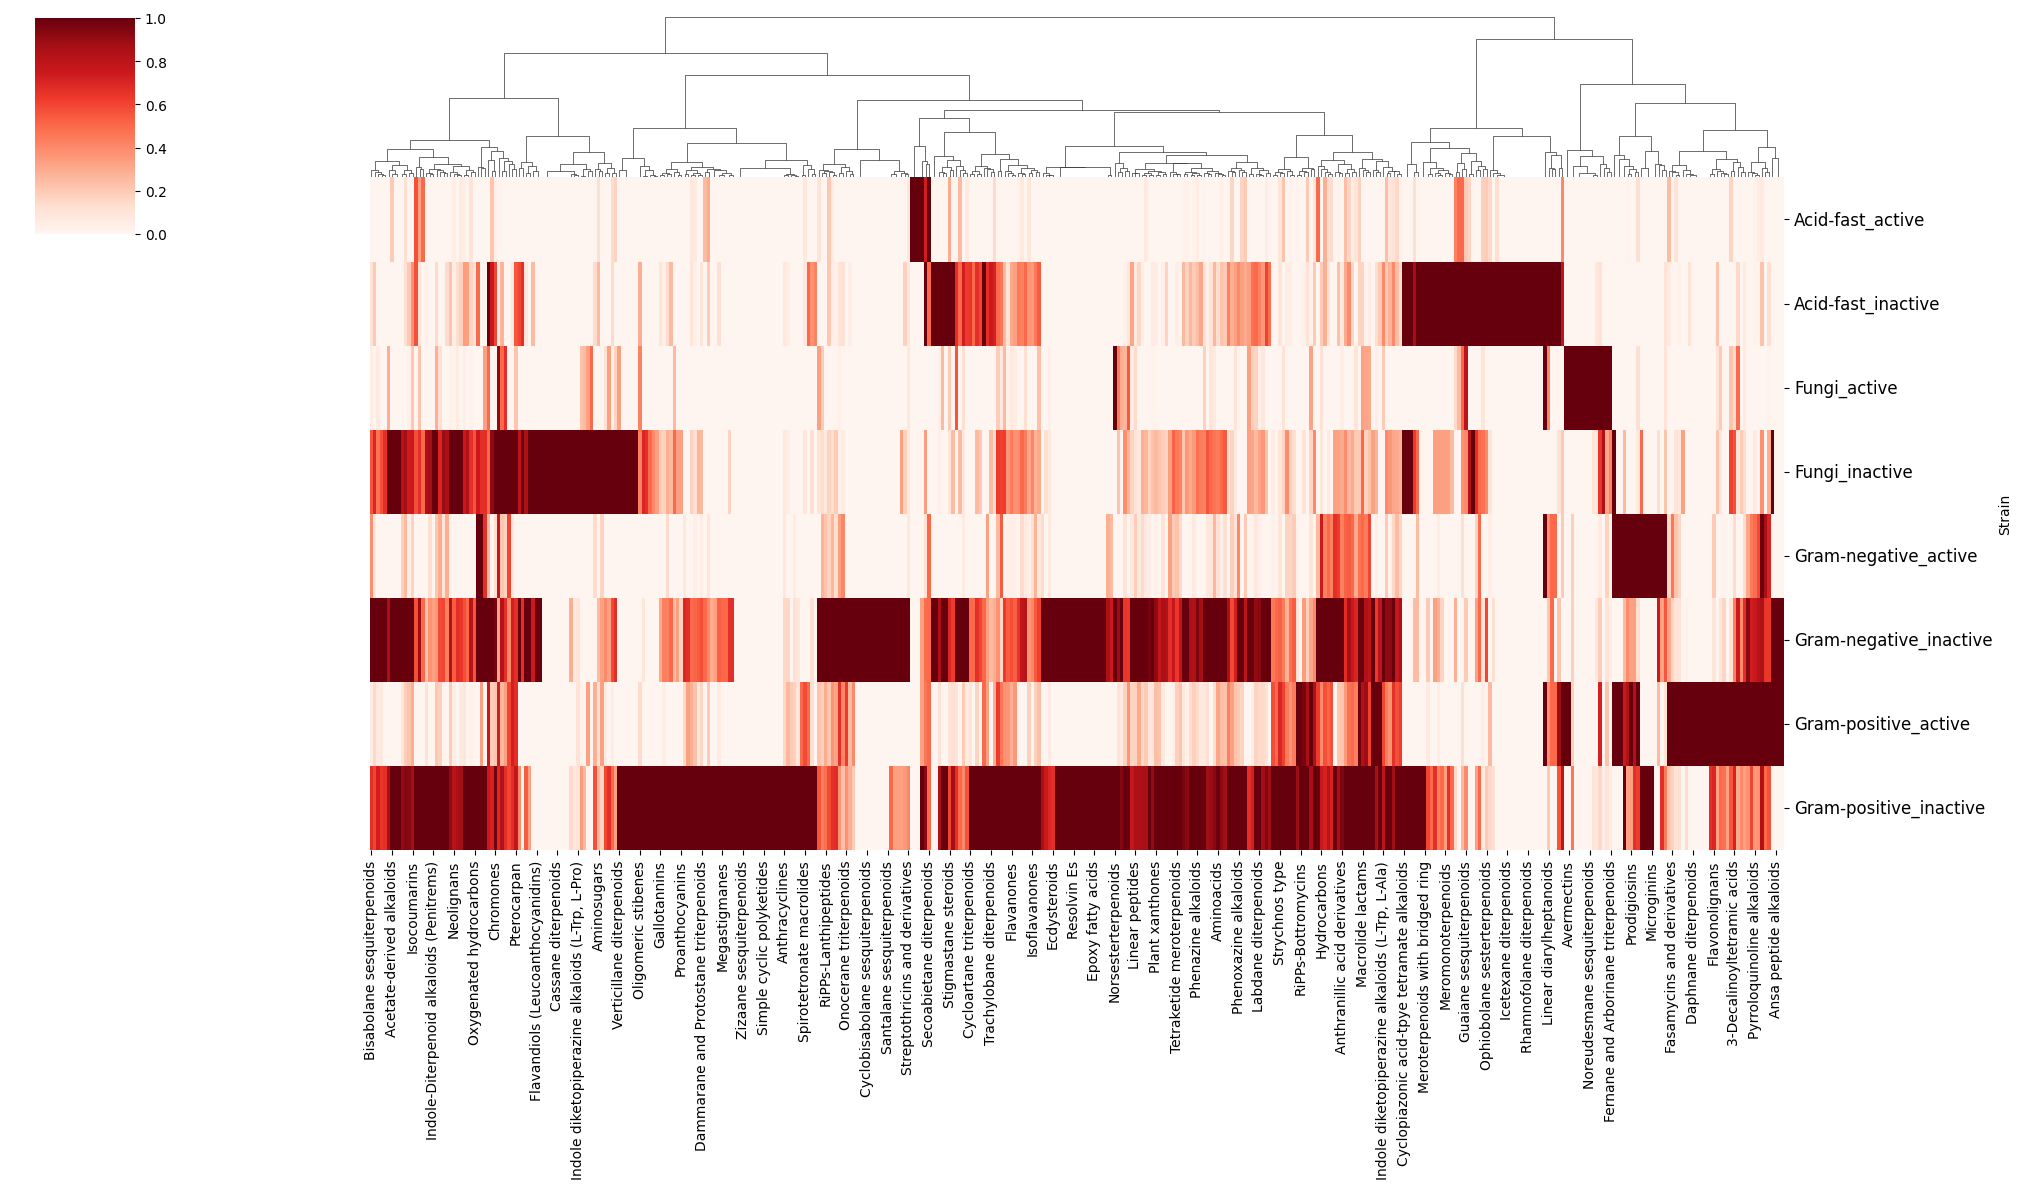

In [16]:
kk = get_cluster_map(chem_class_dict, save_fig=True)

Shape of the dataframe: (5, 411)


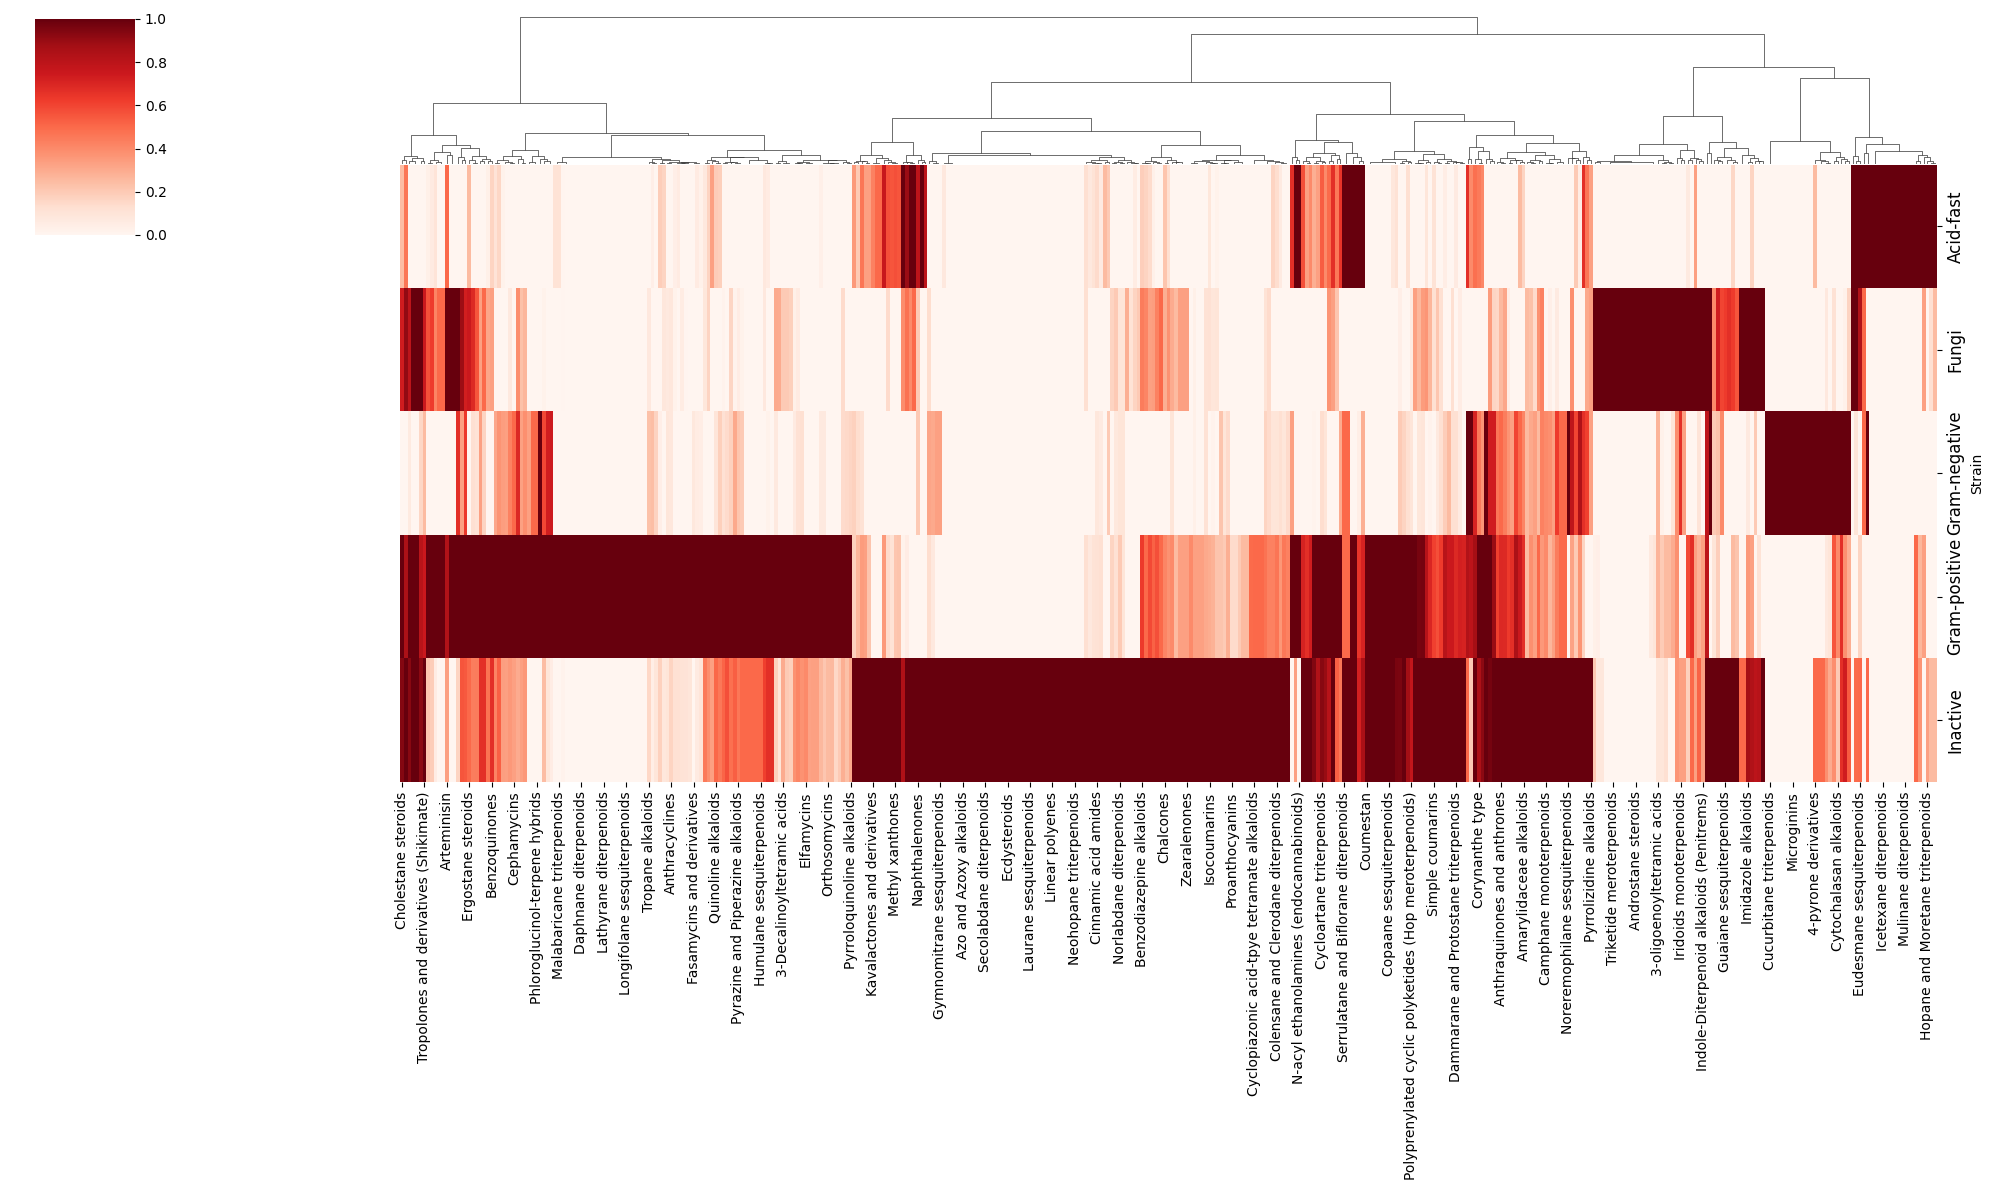

In [17]:
kk = get_cluster_map(chem_class_dict, best_class_only=True)

Shape of the dataframe: (8, 67)


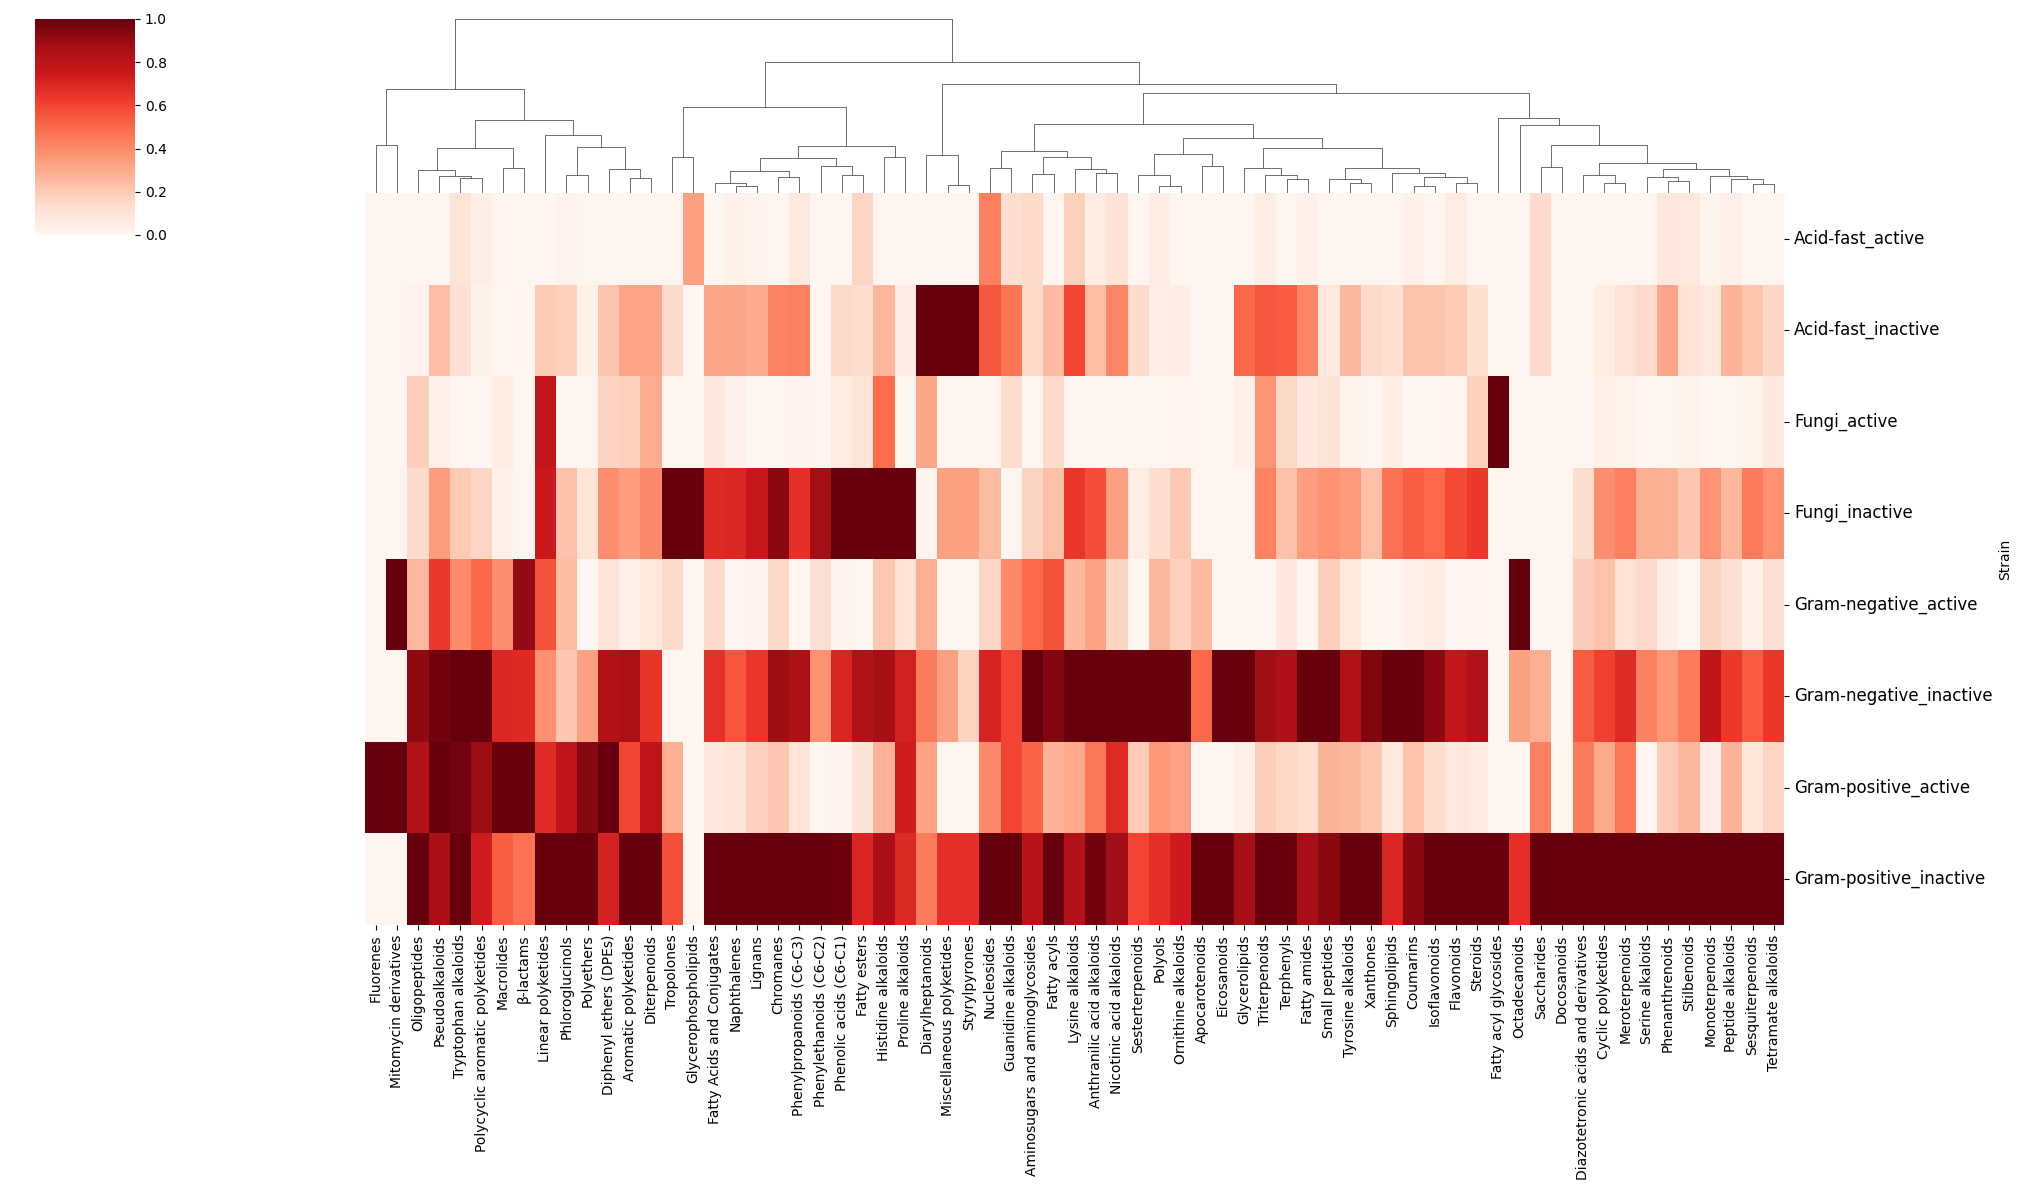

In [18]:
get_cluster_map(chem_superclass_dict)

Shape of the dataframe: (5, 67)


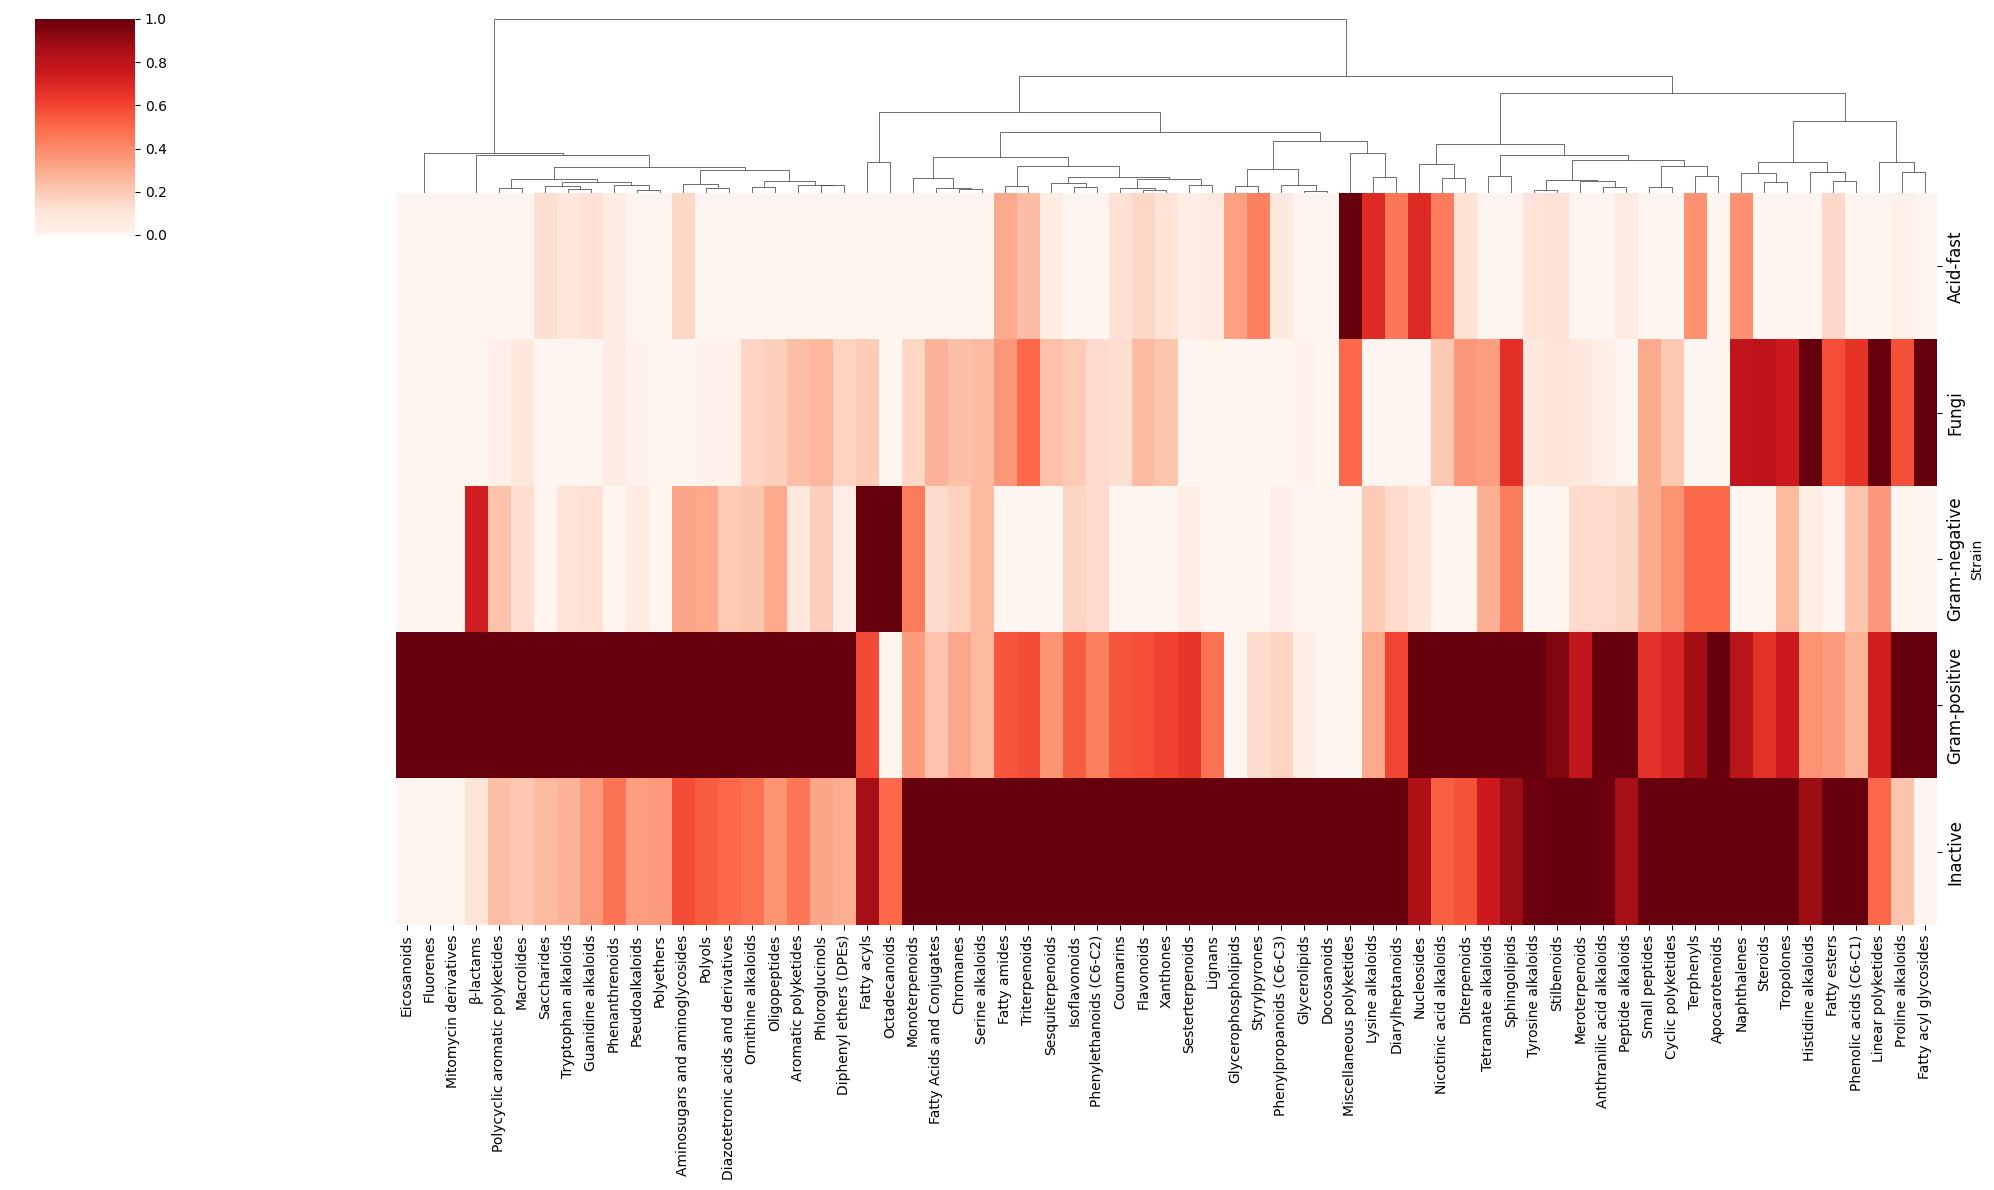

In [19]:
get_cluster_map(chem_superclass_dict, best_class_only=True)

Shape of the dataframe: (8, 7)


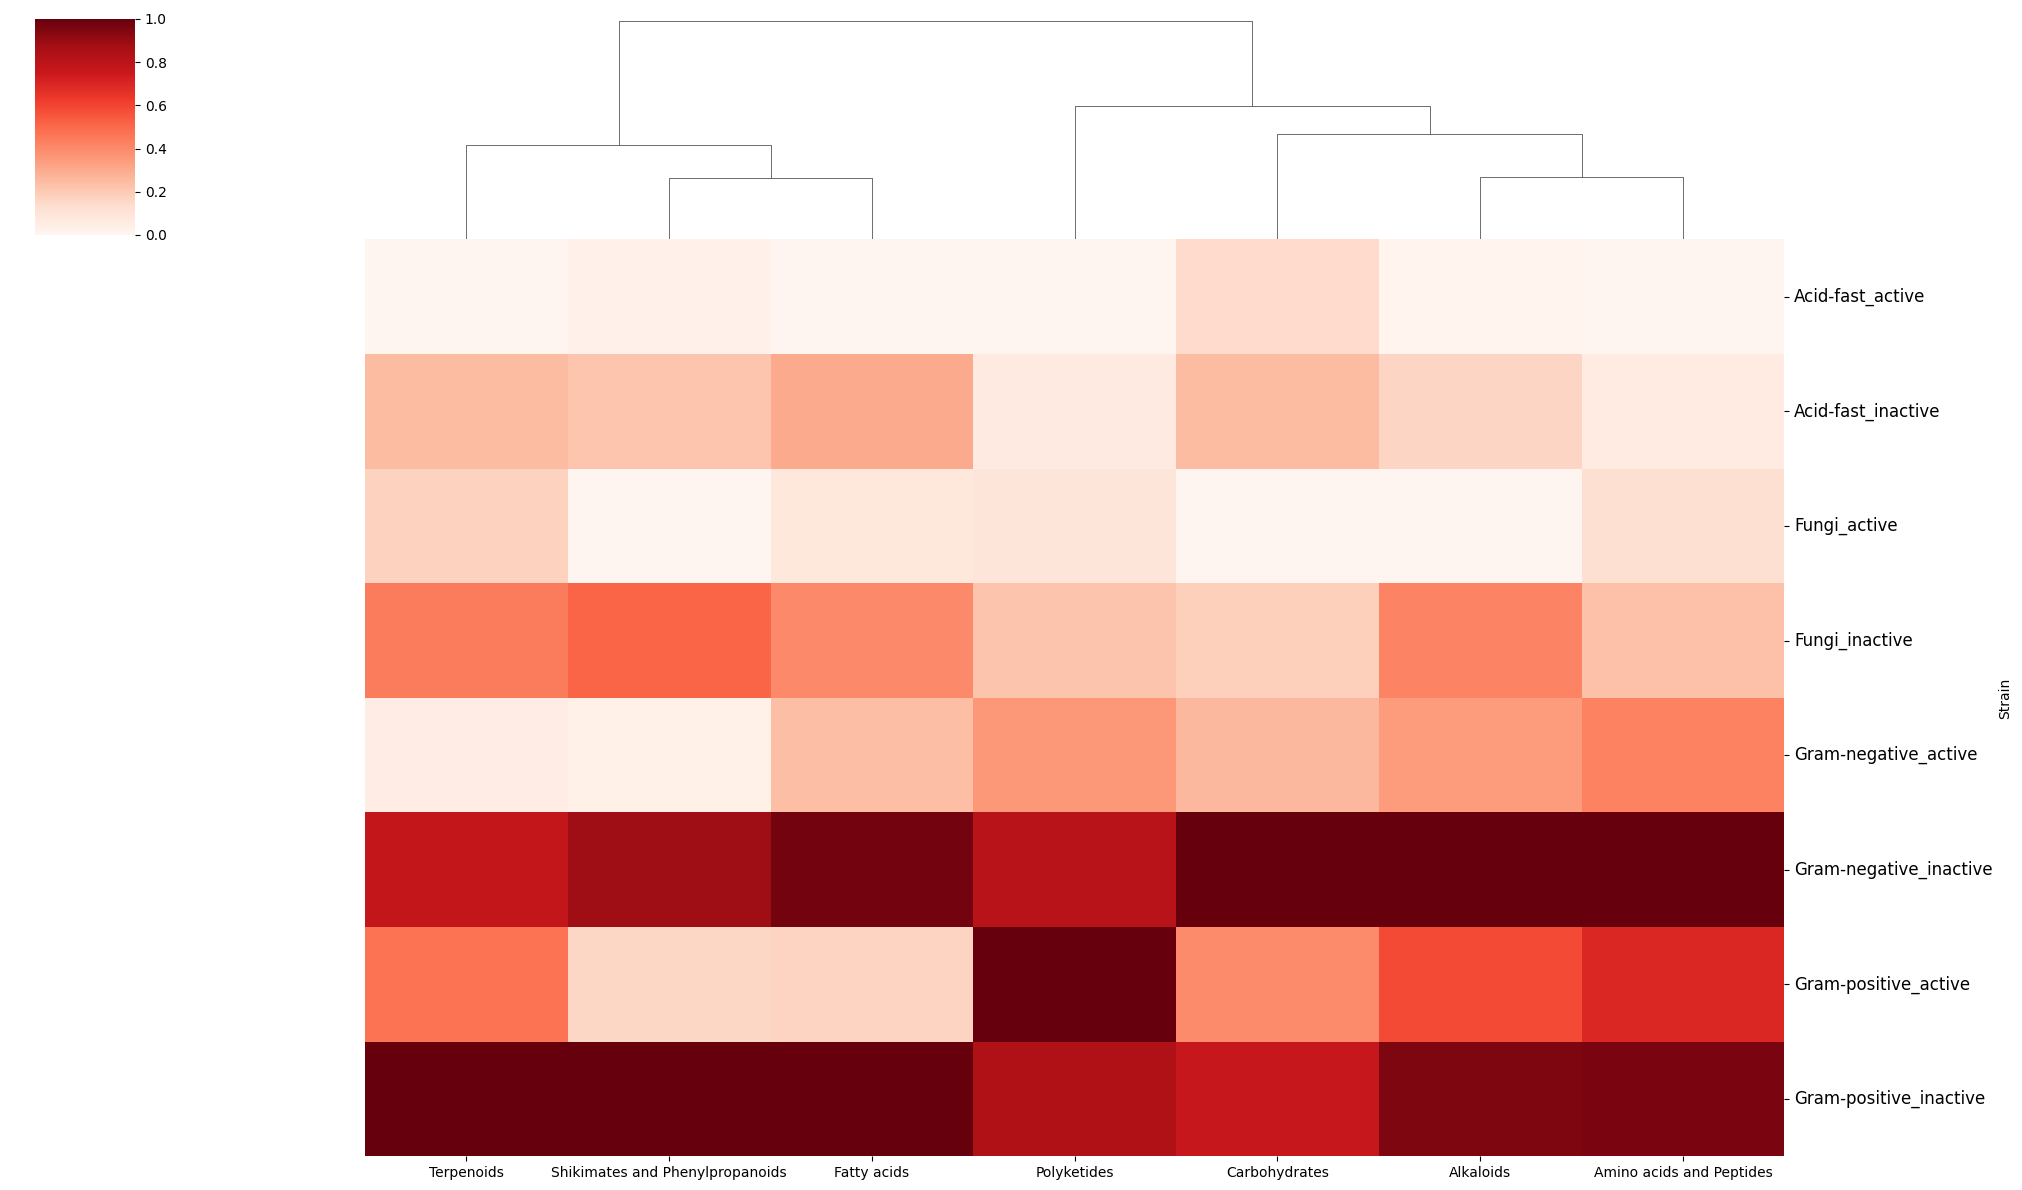

In [20]:
get_cluster_map(chem_pathway_dict)

Shape of the dataframe: (5, 7)


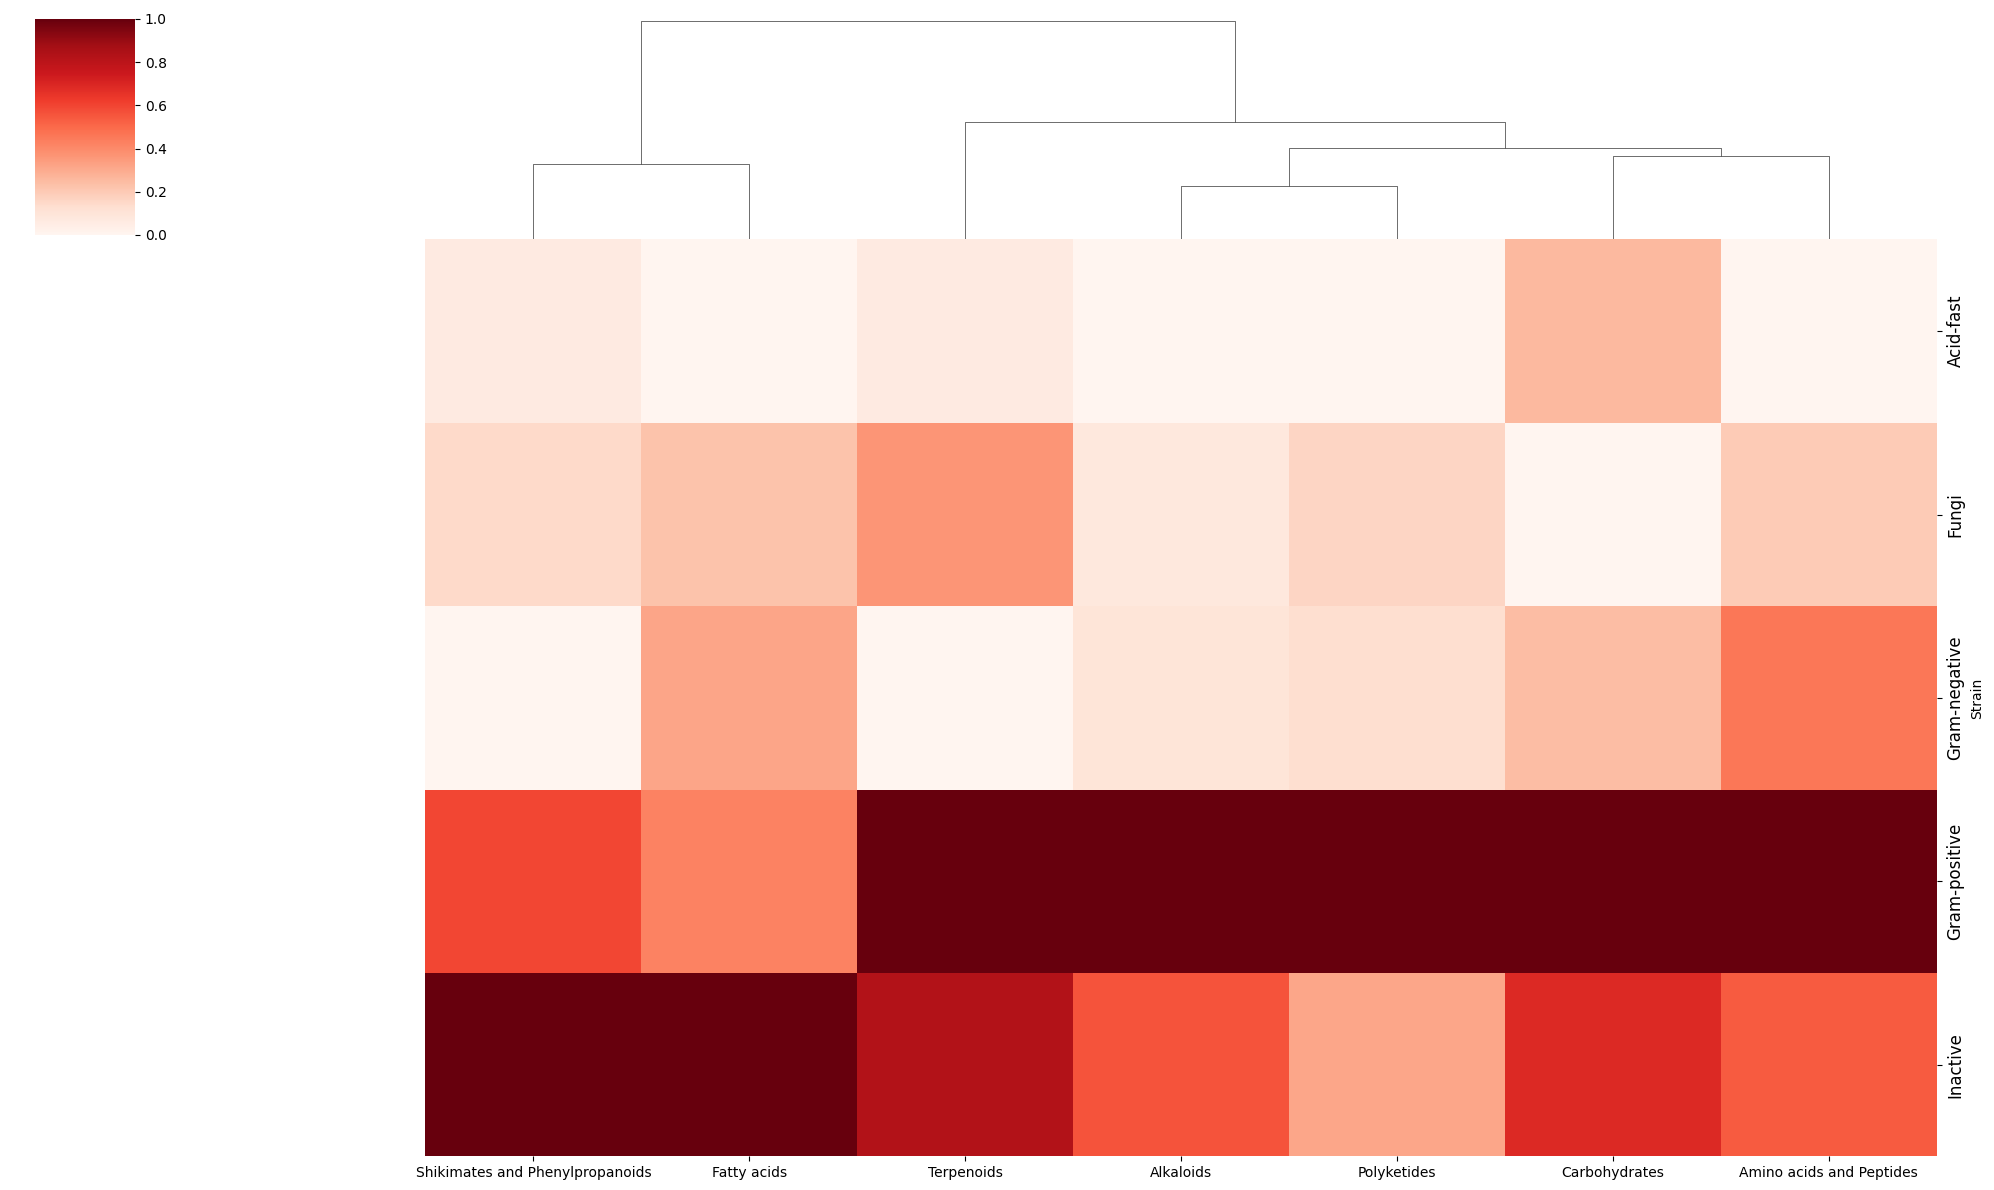

In [21]:
get_cluster_map(chem_pathway_dict, best_class_only=True)

# Deep dive into each category

In [22]:
def get_cluster_map(data_dict, selected_class):
    t = []

    for class_name, class_dict in data_dict.items():
        if selected_class not in class_name:
            continue
        
        if "_" not in class_name:
            continue

        k = defaultdict(int)
        for subclass, compounds in class_dict.items():
            k[subclass] = len(compounds)
        k["Strain"] = class_name.capitalize()
        t.append(k)

    class_df = pd.DataFrame(t)
    class_df.dropna(inplace=True, how="all")
    class_df.sort_values(by="Strain", inplace=True)
    class_df.set_index("Strain", inplace=True)
    class_df = class_df.fillna(0)
    
    # Normalize the data row wise
    scaler = MinMaxScaler()
    class_df = pd.DataFrame(scaler.fit_transform(class_df), columns=class_df.columns, index=class_df.index)
    
    # Sort values such that active compounds are on top
    labels = class_df.index.sort_values()
    class_df = class_df.sort_values(by=labels[0], ascending=False, axis=1)

    # Get count of cols present in active and absent in inactive
    active_cols = set(class_df.columns[class_df.loc[labels[0]] > 0.8])
    inactive_cols = set(class_df.columns[class_df.loc[labels[1]] > 0.8])

    active_only_class = active_cols - inactive_cols
    print(f"Active only class: {active_only_class}, {len(active_only_class)}")
    
    g = sns.clustermap(
        class_df,
        cmap="Reds",
        method="ward",
        figsize=(20, 12),
        standard_scale=1,
        row_cluster=False,
        col_cluster=False,
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_ymajorticklabels(), fontsize=12, va="center"
    )
    plt.suptitle(f"Strain: {selected_class}")
    plt.show()

Active only class: {'Herbertane sesquiterpenoids', 'Fasamycins and derivatives', 'Linear diarylheptanoids', 'Polypodane triterpenoids', 'Terpenoid alkaloids', 'Cannabinoids', 'Amarylidaceae alkaloids', 'Pyrrole alkaloids', 'Daphnane diterpenoids', 'Bafilomycins', 'Podocarpane diterpenoids', 'Macrocyclic tetramic acids', 'Malabaricane triterpenoids', 'Phenethylisoquinoline alkaloids', '3-acyl tetramic acids', 'Marine-bacterial DPEs', 'Flavonolignans', 'Vancomycins and Teicoplanins', 'Anthocyanidins', 'Sacculatane diterpenoids', 'Norkaurane diterpenoids', 'Pachydictyane diterpenoids', 'Ansa peptide alkaloids', 'Pentacyclic guanidine alkaloids', 'Polyene macrolides', 'Tetracyclines', 'Actinomycins', 'Steroidal alkaloids', 'Phloroglucinol-terpene hybrids', 'Bicyclic guanidine alkaloids', 'Tylosins', 'Cephalosporins', 'Onocerane triterpenoids', 'Pyrroloquinoline alkaloids', 'N-acyl ethanolamines (endocannabinoids)', 'Hirsutane sesquiterpenoids', 'Depsidones', 'Ansa macrolides', 'Erythromyci

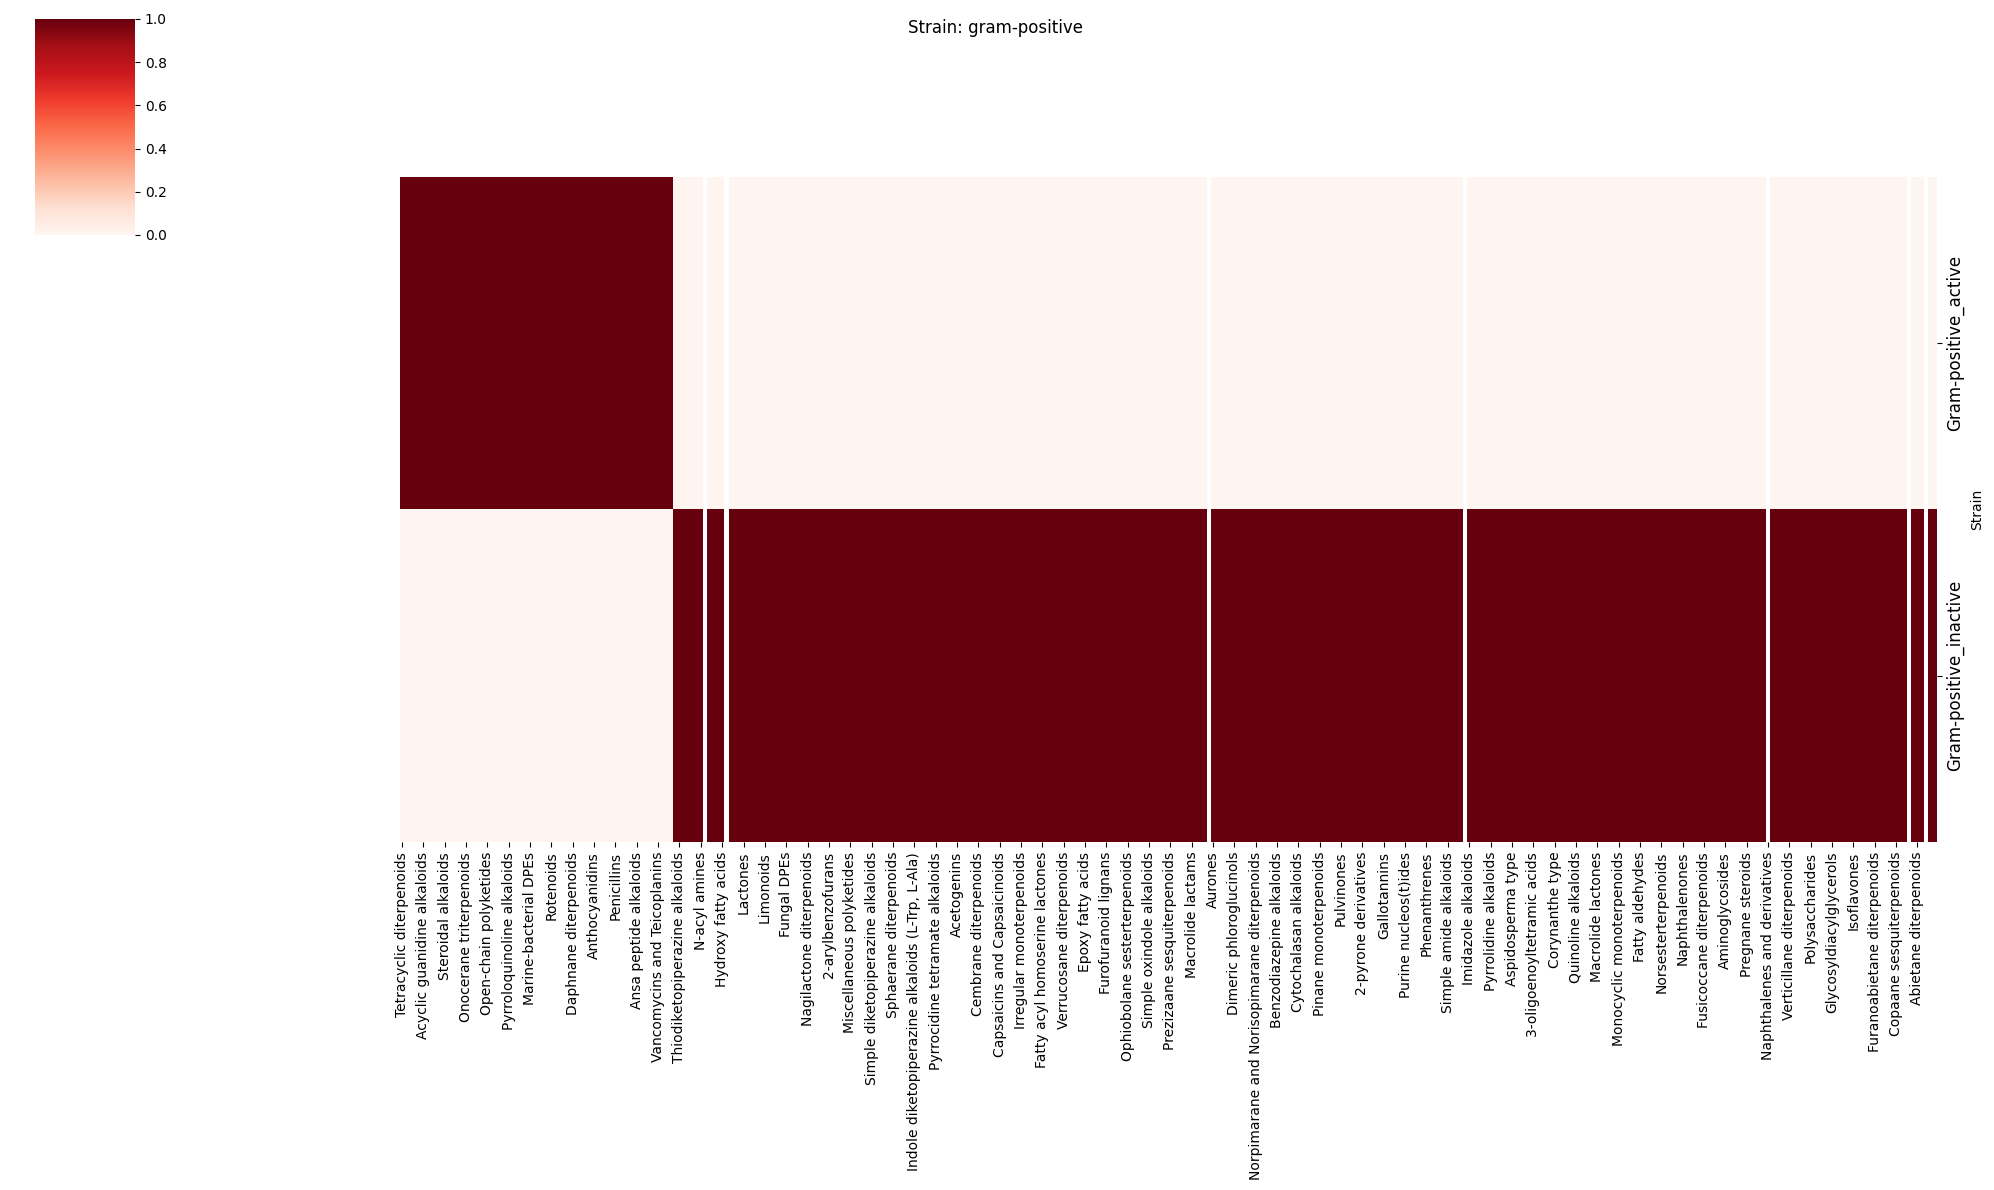

In [23]:
get_cluster_map(chem_class_dict, "gram-positive")

Active only class: {'Linear diarylheptanoids', 'Fasamycins and derivatives', 'Dicarboxylic acids', 'Prenylated,geranylated phloroglucinols', 'Other Octadecanoids', 'Flavonolignans', 'Norkaurane diterpenoids', 'Pachydictyane diterpenoids', 'Phthalide derivatives', 'Pentacyclic guanidine alkaloids', 'Polyene macrolides', 'Apocarotenoids (β-)', 'Steroidal alkaloids', 'Phloroglucinol-terpene hybrids', 'Aporphine alkaloids', 'Microginins', 'Cephalosporins', 'Tropolones and derivatives (Shikimate)', 'Aromadendrane sesquiterpenoids', 'N-acyl ethanolamines (endocannabinoids)', 'Benzophenones', 'Aeruginosins', 'Rotenoids', 'Tropane alkaloids', 'Ericamycins', 'Prodigiosins', 'Tetrahydroisoquinoline alkaloids', 'Clavams', 'Acridone alkaloids', 'Carbapenems', 'Mitomycins', 'Open-chain polyketides', 'Terpenoid alkaloids', 'Pinguisane sesquiterpenoids'}, 34


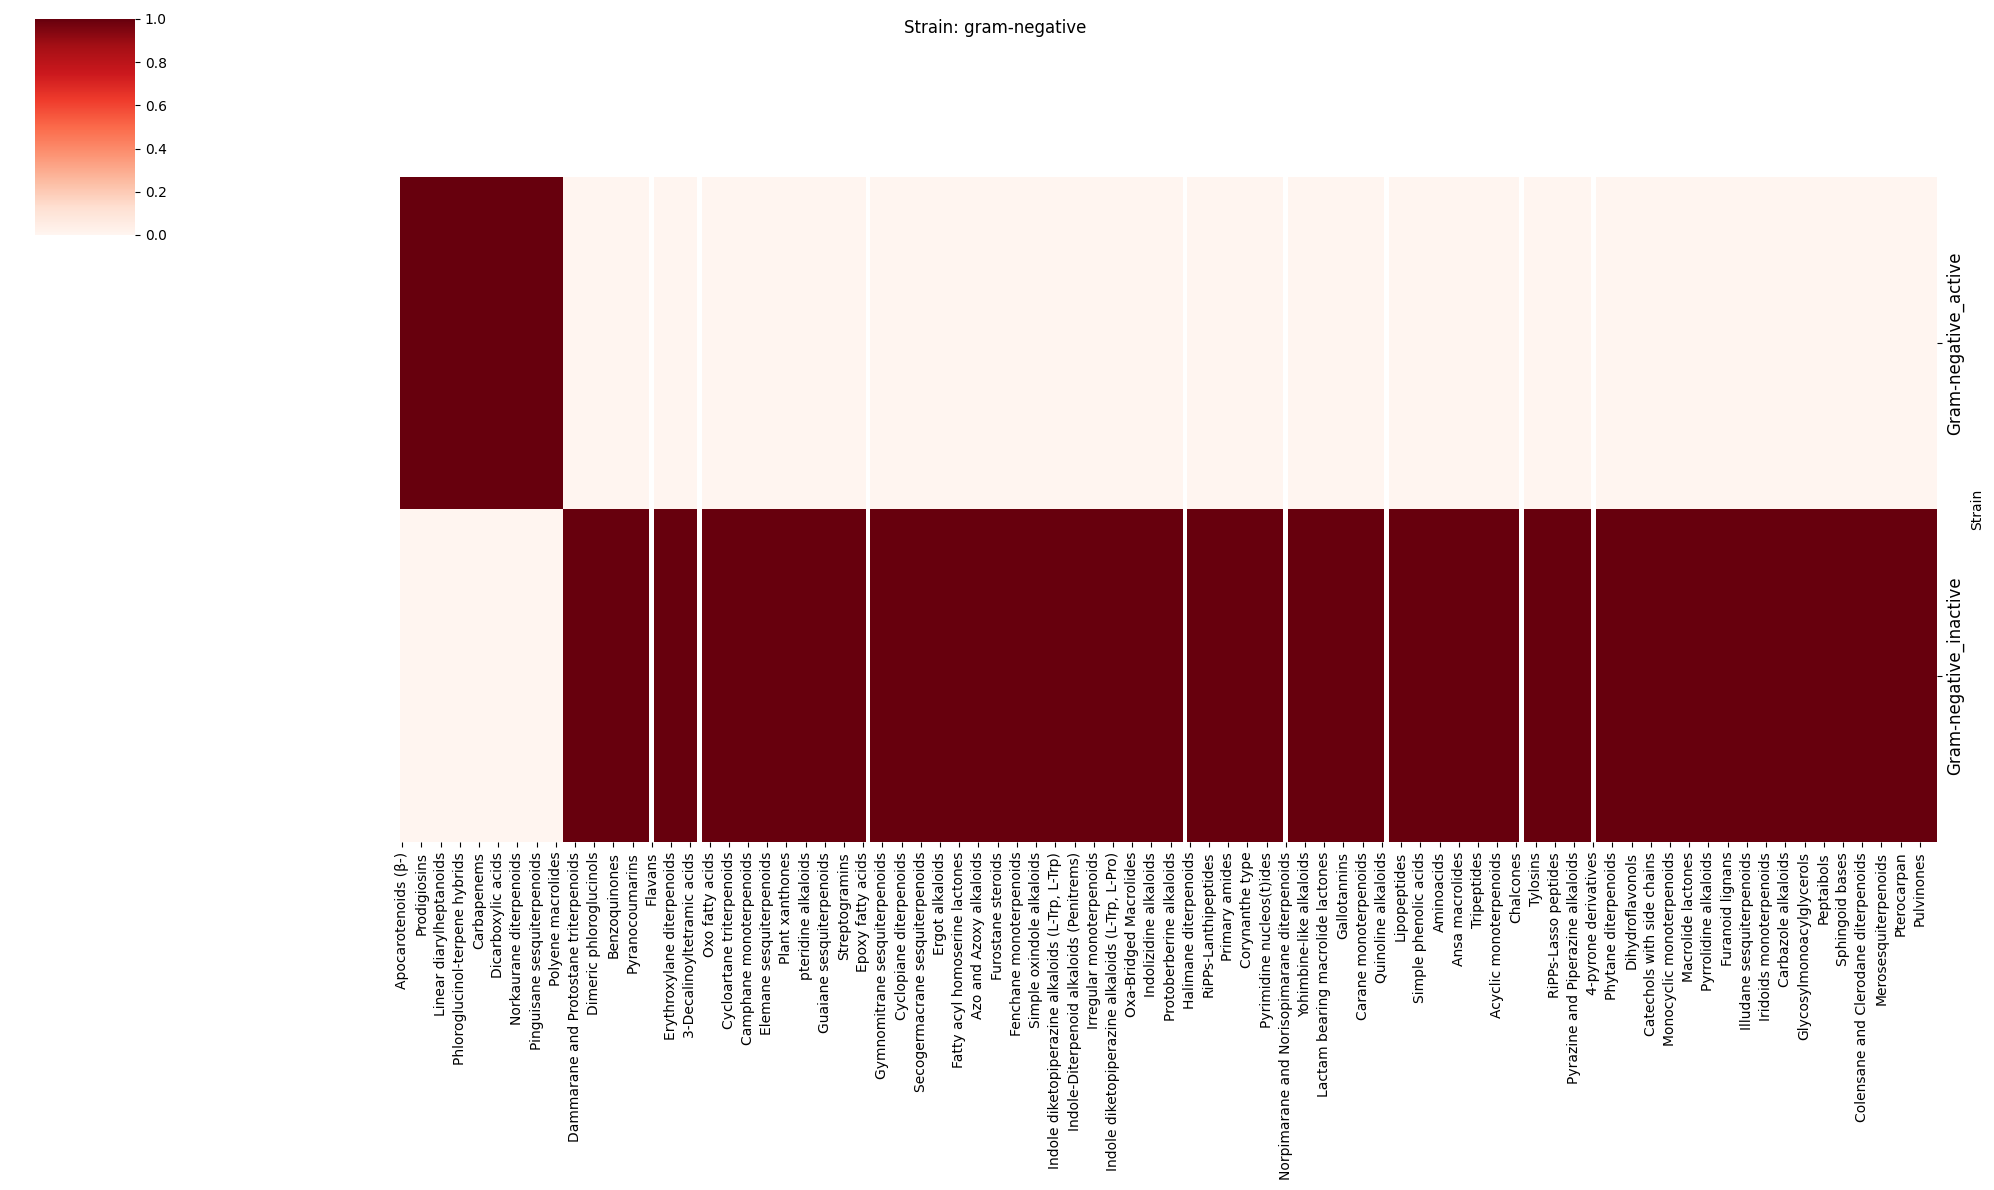

In [24]:
get_cluster_map(chem_class_dict, "gram-negative")

Active only class: {'Lactones', 'Linear diarylheptanoids', 'Linear peptides', 'Indolizidine alkaloids', 'Cannabinoids', 'Indole diketopiperazine alkaloids (L-Trp, L-Ala)', 'Glycosylmonoacylglycerols', 'Halogenated hydrocarbons', 'Protoberberine alkaloids', 'Nonadrides', 'Stigmastane steroids', 'Rhizoxins', 'Vancomycins and Teicoplanins', 'Tricyclic guanidine alkaloids', 'Noreudesmane sesquiterpenoids', 'Primary amides', 'Cyclic peptides', 'Oligomycins', 'Cedrane and Isocedrane sesquiterpenoids', 'Polyene macrolides', 'Dipeptides', '3-oligoenoyltetramic acids', 'Aporphine alkaloids', 'Serratane triterpenoids', 'N-acyl ethanolamines (endocannabinoids)', 'Depsides', 'Ascomycins and Rapamycins', 'Lipopeptides', 'Ergostane steroids', 'Norsesterterpenoids', 'Hirsutane sesquiterpenoids', 'Depsidones', 'Tropane alkaloids', 'Tetracyclic diterpenoids', 'Pyrazine and Piperazine alkaloids', 'Fernane and Arborinane triterpenoids', 'Depsipeptides', 'Avermectins', 'Guaiane sesquiterpenoids', 'Hydroca

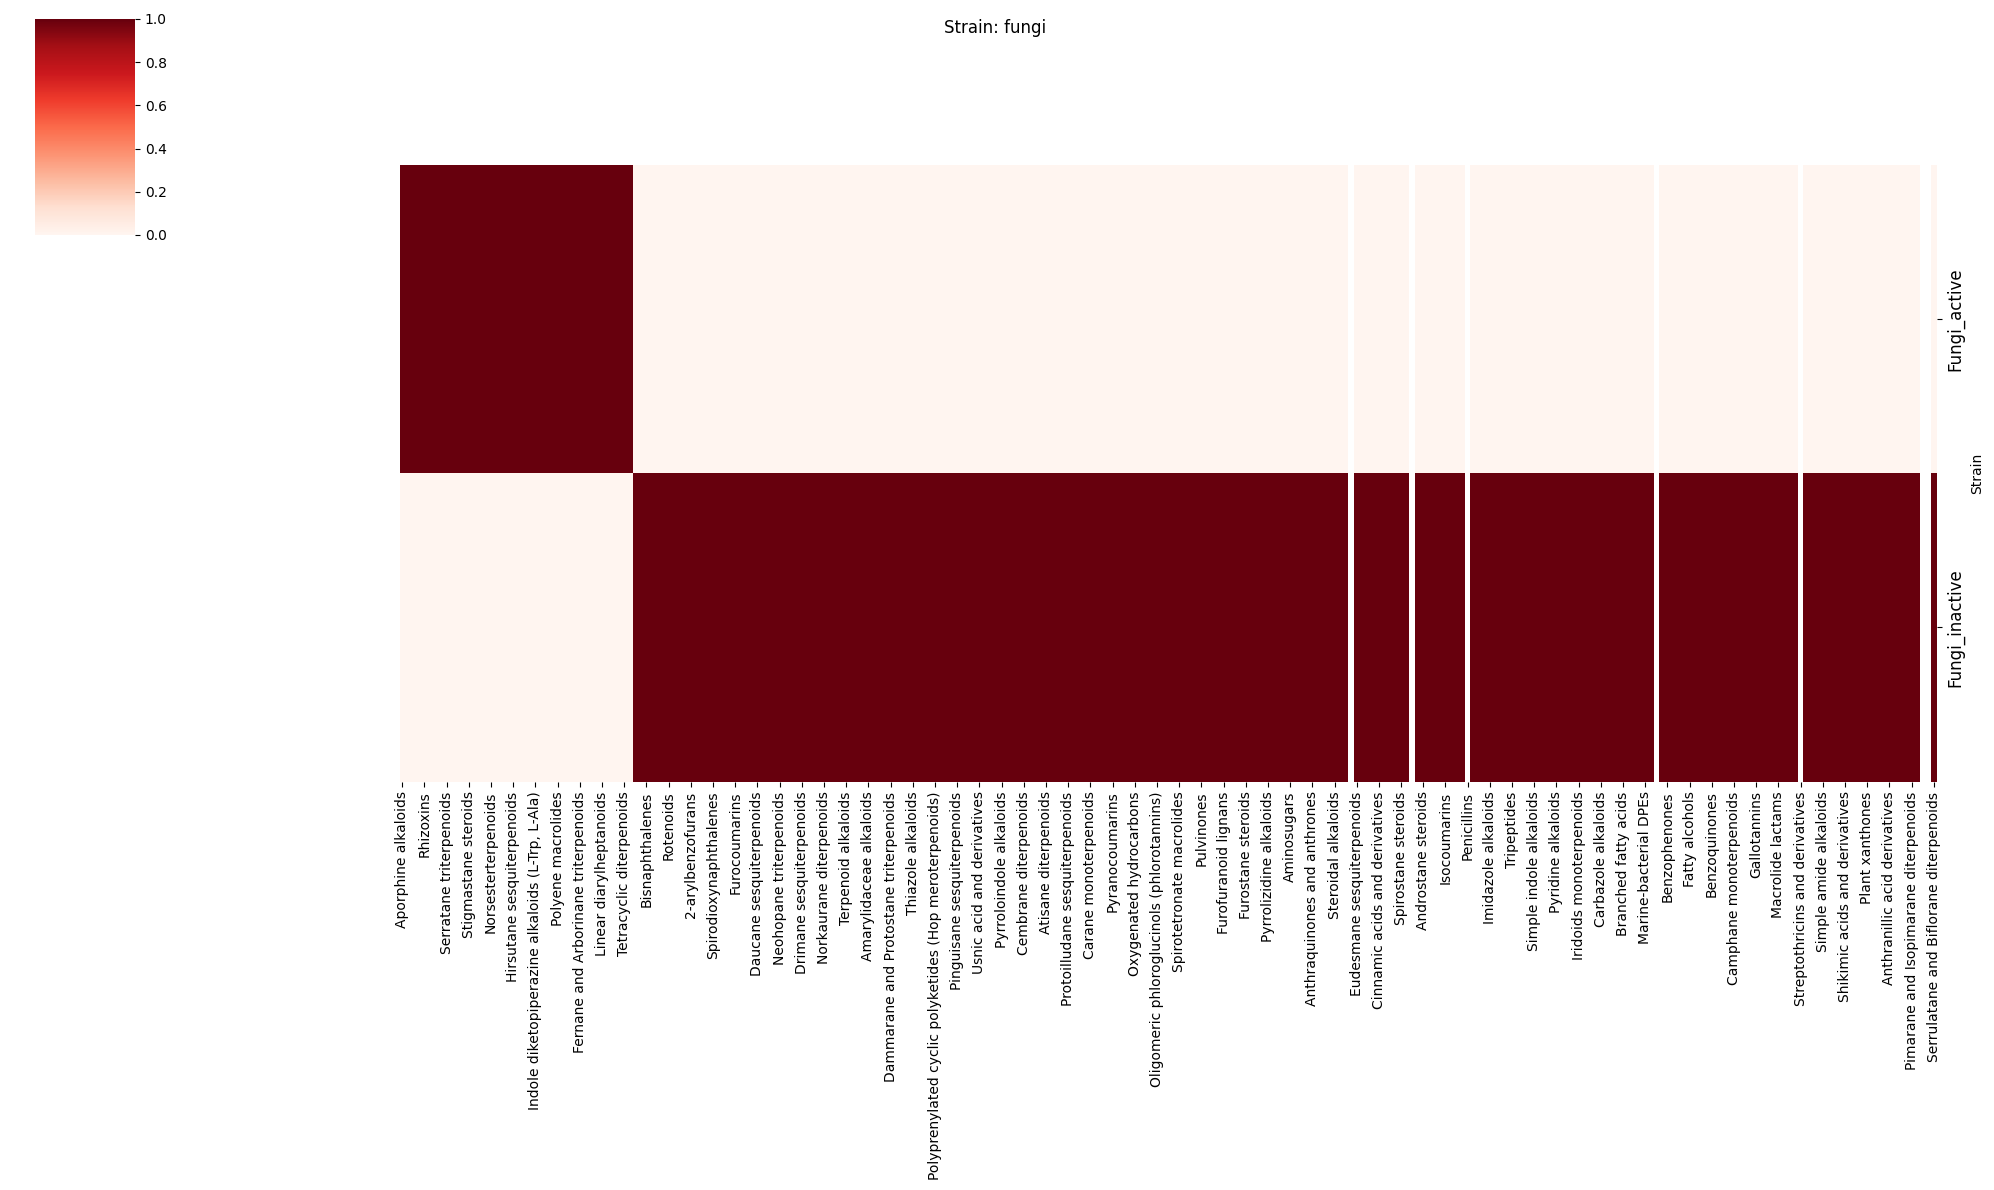

In [25]:
get_cluster_map(chem_class_dict, "fungi")

Active only class: {'Lactones', 'Polysaccharides', 'Aminoglycosides', 'Carboline alkaloids', 'Secoabietane diterpenoids', 'Cephamycins', 'Corynanthe type', 'Illudalane sesquiterpenoids', 'Amino cyclitols', 'Clovane sesquiterpenoids', 'Acetate-derived alkaloids', 'Tetracyclines', 'Peptaibols', 'Actinomycins', 'Abeoabietane diterpenoids', 'Aspidosperma-Iboga hybrid type (Vinca alkaloids)', 'Arteminisin', 'Germacrane sesquiterpenoids', 'Yohimbine-like alkaloids', 'Dimeric phloroglucinols', 'Ansa macrolides', 'Long-Chain Bicyclic Phosphotriester', 'Ericamycins', 'Tropane alkaloids', 'Abietane diterpenoids', 'Furans', 'Taraxerane triterpenoids', 'Carbapenems', 'Purine nucleos(t)ides', 'Platensimycin and Platencins', 'RiPPs-Thiopeptides'}, 31


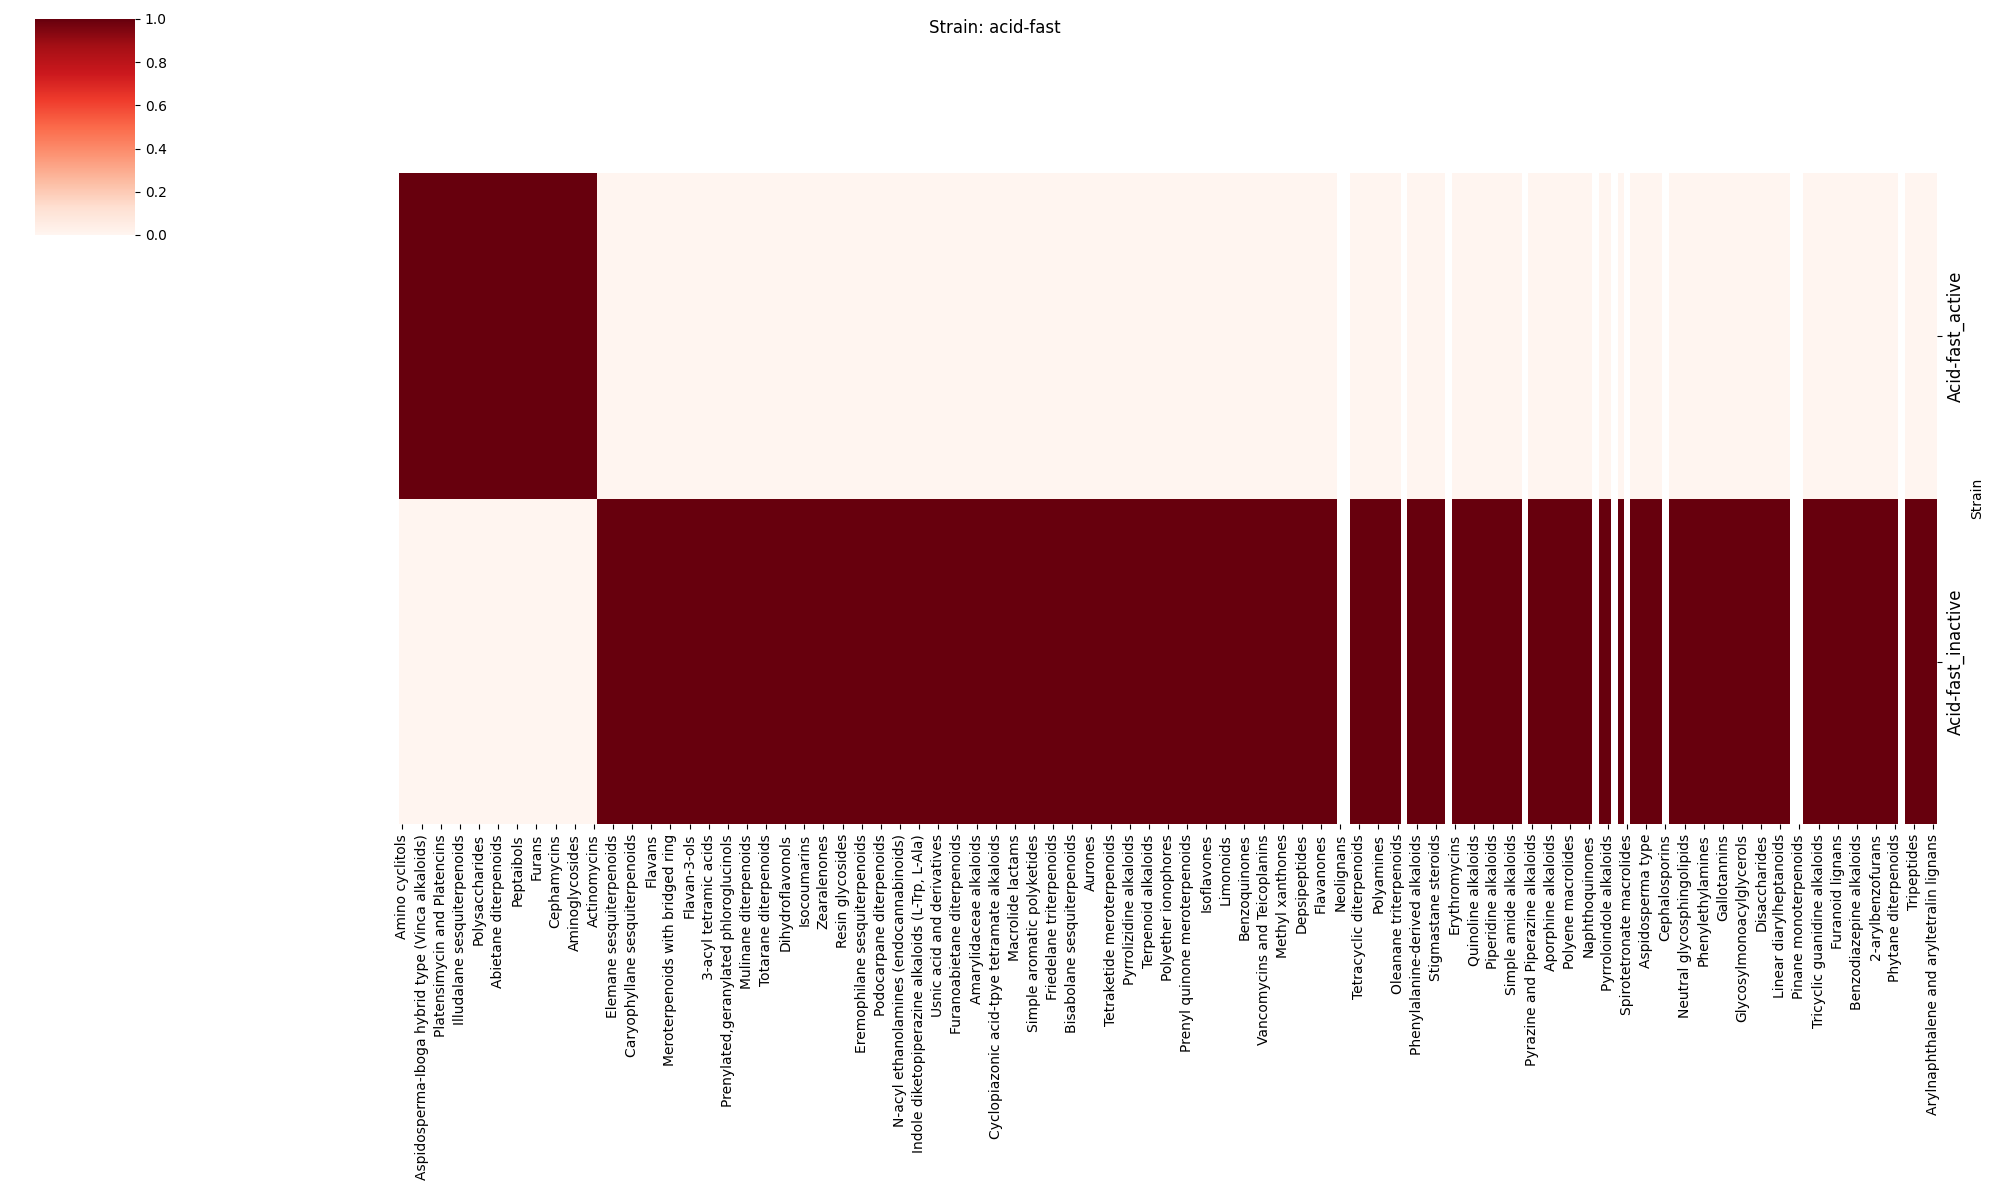

In [26]:
get_cluster_map(chem_class_dict, "acid-fast")

Active only class: {'Polyketides'}, 1


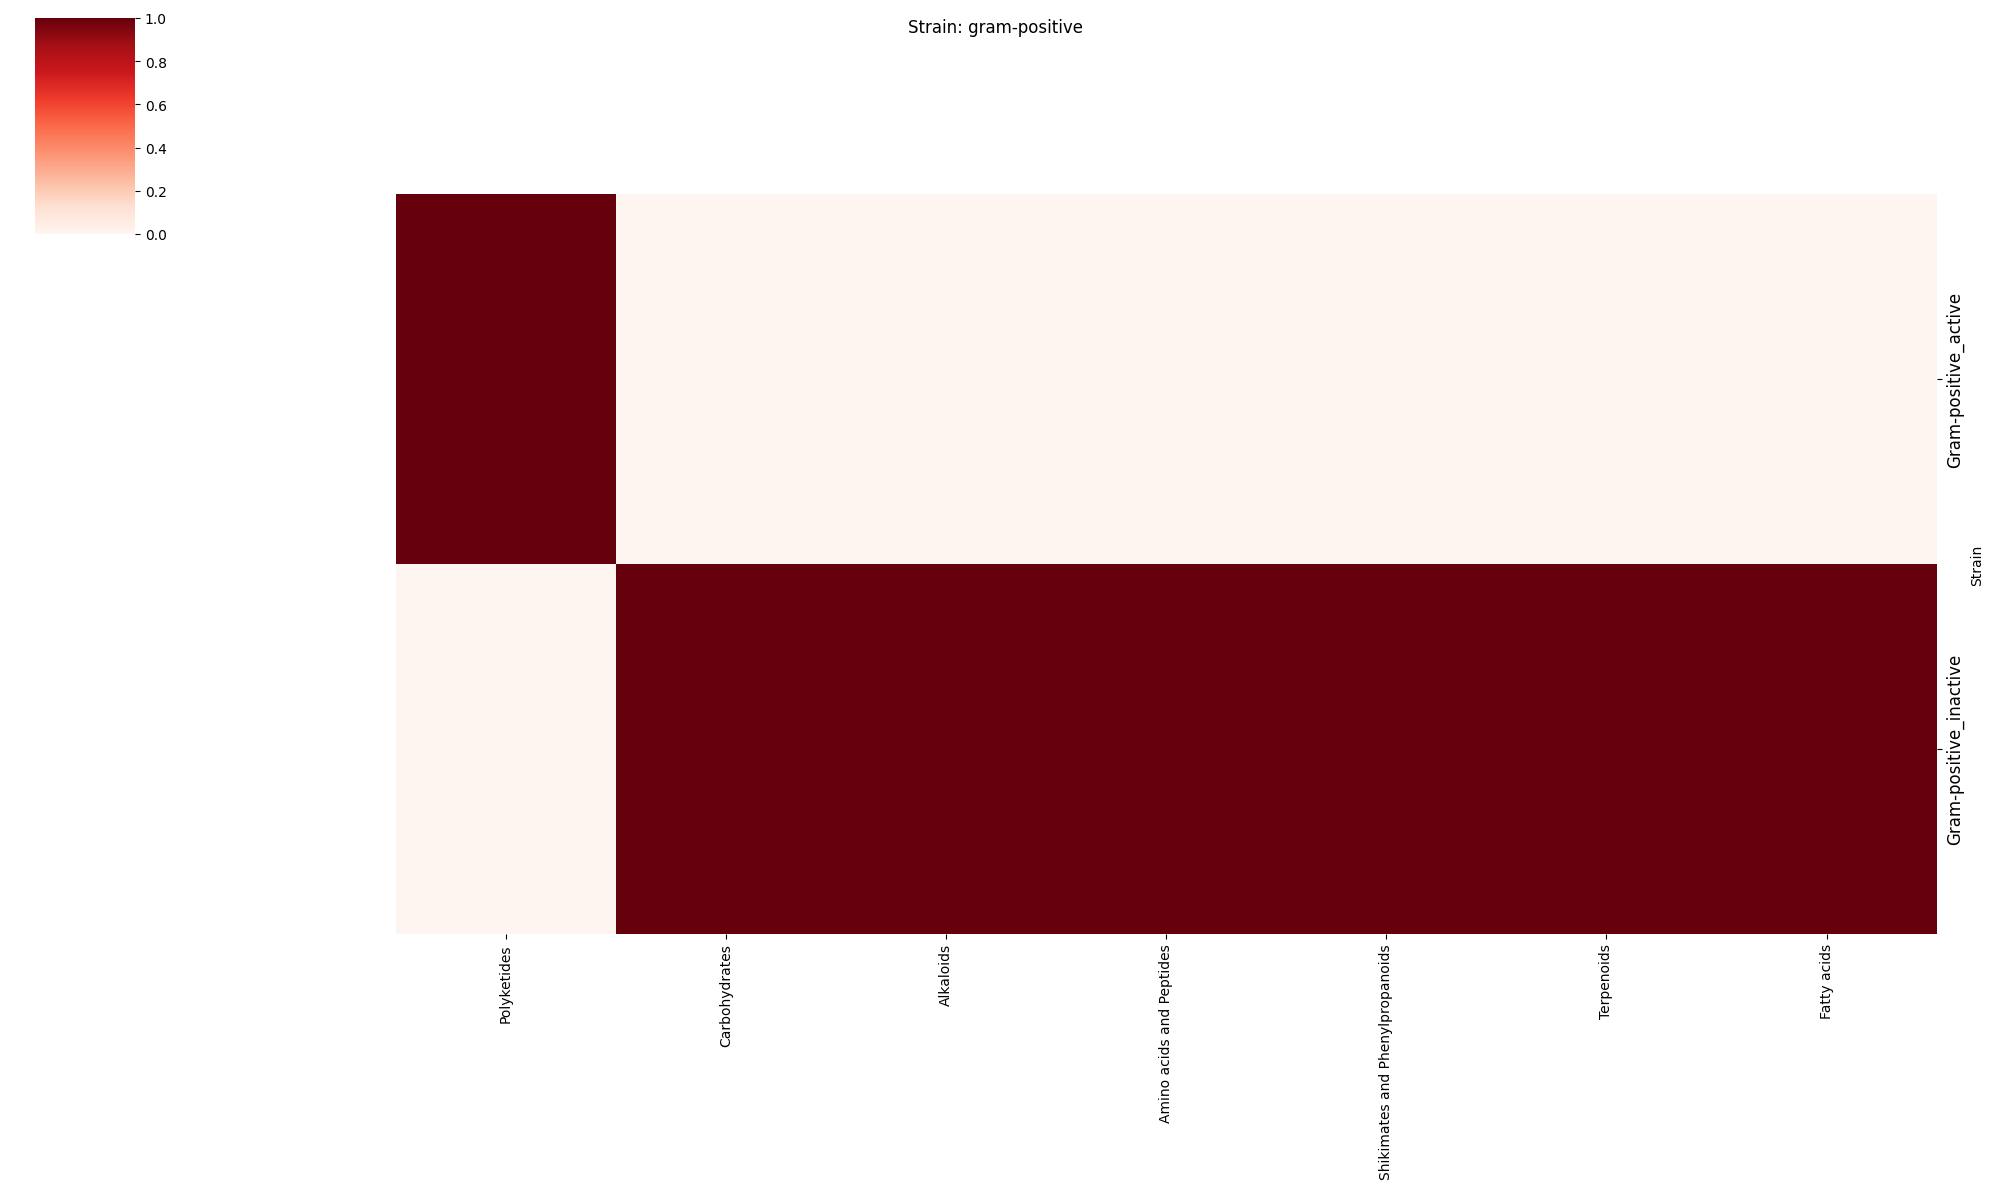

In [27]:
get_cluster_map(chem_pathway_dict, "gram-positive")